In [1]:
import copy
import glob
import gzip
import json
import os
import pickle
import shutil
import sys
import time
import warnings
import zipfile
import numba
from datetime import date
import h5py 

import cdsapi
import numpy as np
import pandas as pd
import xarray as xr


import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
import seaborn

import trajectory as trj
from collections import defaultdict

sys.path.insert(0, os.getcwd() + "/../resort/rasotools-master/")
import rasotools


from windrose import WindroseAxes

In [6]:
matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (20, 10)
font = {
    "size": 20,
}
matplotlib.rc("font", **font)

warnings.filterwarnings("ignore")

%load_ext line_profiler


In [2]:
# @numba.jit(nopython=True)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# @numba.jit()
def drop_dims(input_array):
    input_array = np.array(input_array)
    dim = []
    for i in list(np.shape(input_array)):
        if i != 1:
            dim.append(i)
    return input_array.reshape(dim)

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

In [7]:
out = {'id':[], 'name':[], 'start':[], 'end':[], 'lat':[], 'lon':[], 'wdir':[], 'wspd':[]}
for dir_i in ['*-0-110*.nc', '*-0-111*.nc', '*-0-112*.nc','*-0-113*.nc']:
    for i in glob.glob( '/mnt/users/scratch/leo/scratch/converted_v11/long/' + dir_i ):
        with h5py.File(i, 'r') as file:
            try:
                idx_d = file['recordindices']['106'][:]
                idx_s = file['recordindices']['107'][:]
            except:
                continue
            out['id'].append(i.split('/')[-1])
            out['name'].append(b''.join(file['station_configuration']['station_name'][0]).decode('UTF-8'))
            out['start'].append(seconds_to_datetime(file['recordindices']['recordtimestamp'][0]))
            out['end'].append(seconds_to_datetime(file['recordindices']['recordtimestamp'][-1]))
            out['lat'].append(file['observations_table']['latitude'][-1])
            out['lon'].append(file['observations_table']['longitude'][-1])
            out['wdir'].append(file['observations_table']['observation_value'][idx_d[0]:idx_d[-1]])
            out['wspd'].append(file['observations_table']['observation_value'][idx_s[0]:idx_s[-1]])

In [8]:
df = pd.DataFrame.from_dict(out)
for i in range(len(df)):
    filter_i = np.logical_and(df.wspd[i] >= 0, df.wspd[i] <= 50)
    df.wdir[i] = np.array(df.wdir[i][filter_i])
    df.wspd[i] = np.array(df.wspd[i][filter_i])

LINZ-STADT 0-20000-0-11060_CEUAS_merged_v1.nc 527 days 12:00:00


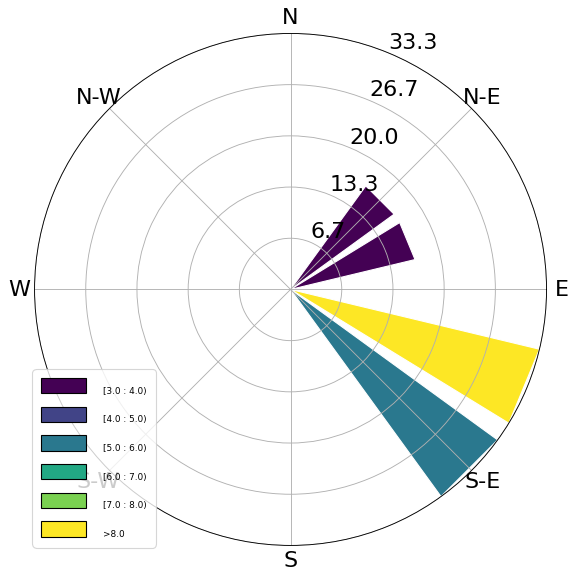

WOLFSEGG 0-20000-0-11001_CEUAS_merged_v1.nc 1411 days 12:00:00


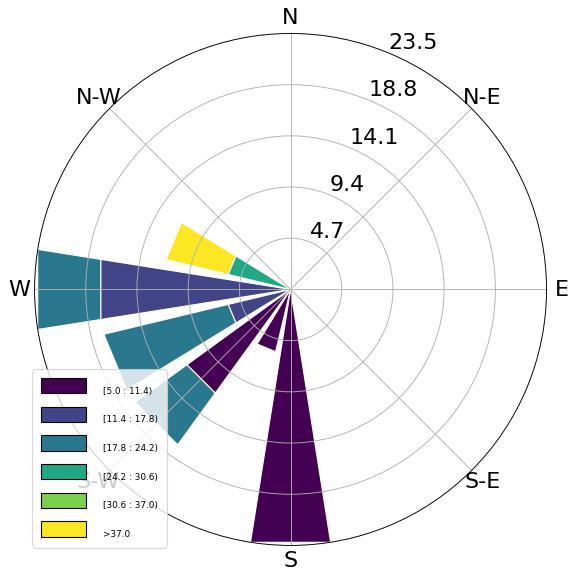

LINZ/HOERSCHING-FLUGHAFEN 0-20000-0-11010_CEUAS_merged_v1.nc 42731 days 18:15:04


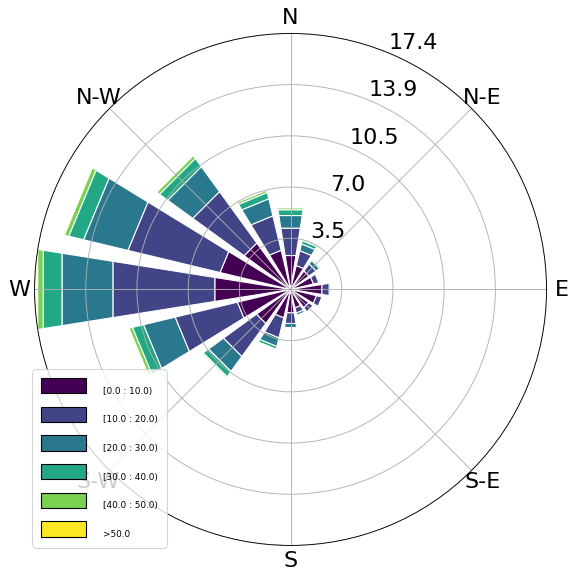

RIED IM INNKREIS 0-20000-0-11053_CEUAS_merged_v1.nc 1403 days 12:00:00


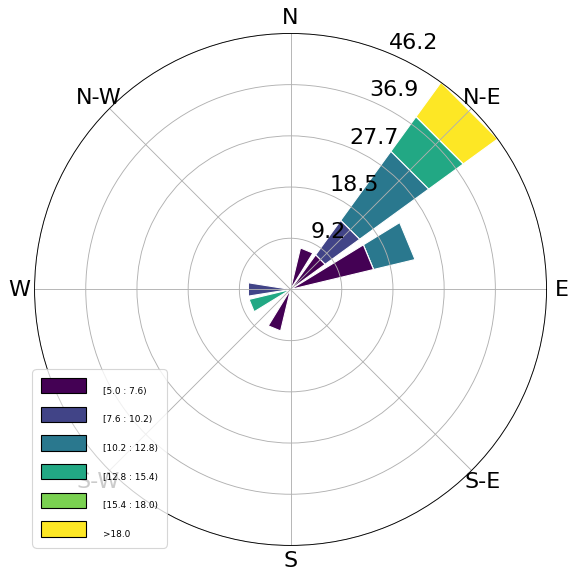

JAUERLING 0-20000-0-11024_CEUAS_merged_v1.nc 1277 days 06:00:00


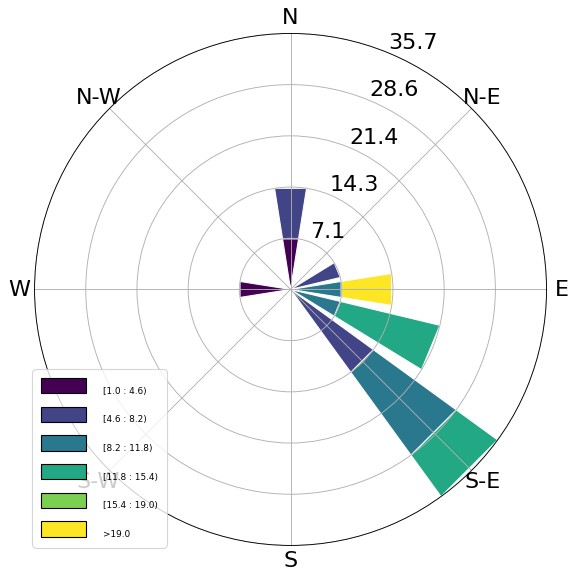

WIEN/HOHE WARTE (11035-1) 0-20001-0-11035_CEUAS_merged_v1.nc 43097 days 02:30:23


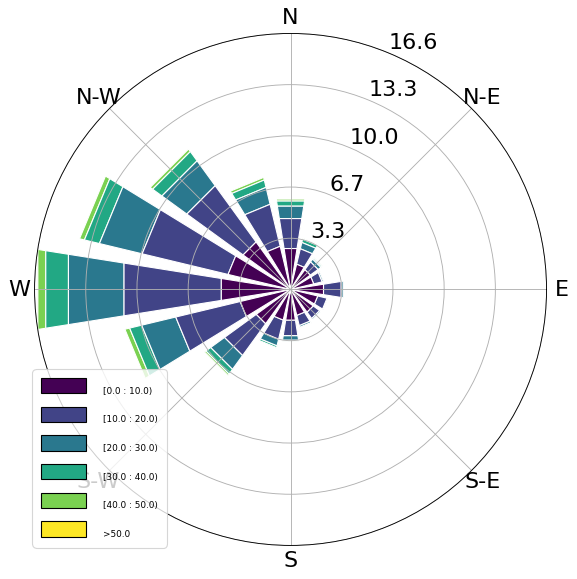

INNSBRUCK-FLUGHAFEN 0-20000-0-11120_CEUAS_merged_v1.nc 40894 days 18:45:05


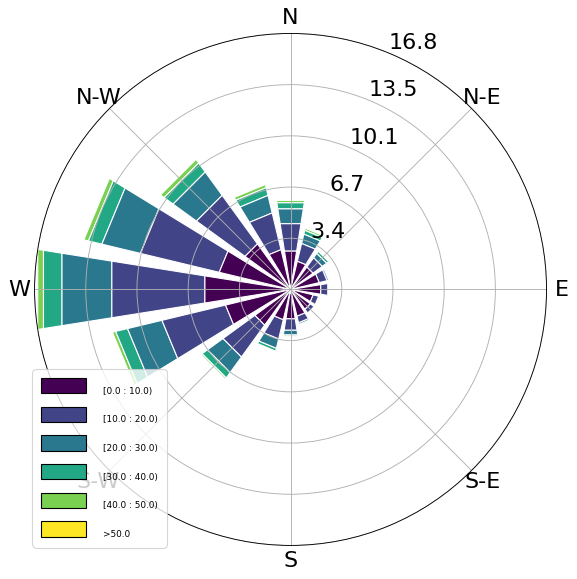

KLEINZICKEN 0-20000-0-11192_CEUAS_merged_v1.nc 1424 days 18:00:00


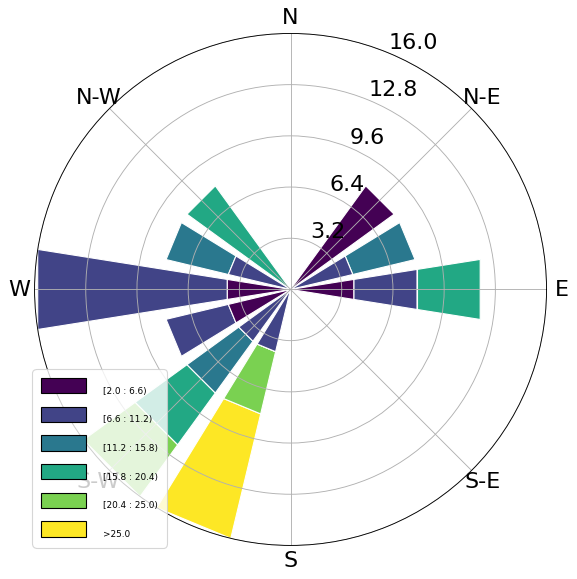

GALZIG 0-20000-0-11110_CEUAS_merged_v1.nc 6100 days 15:00:00


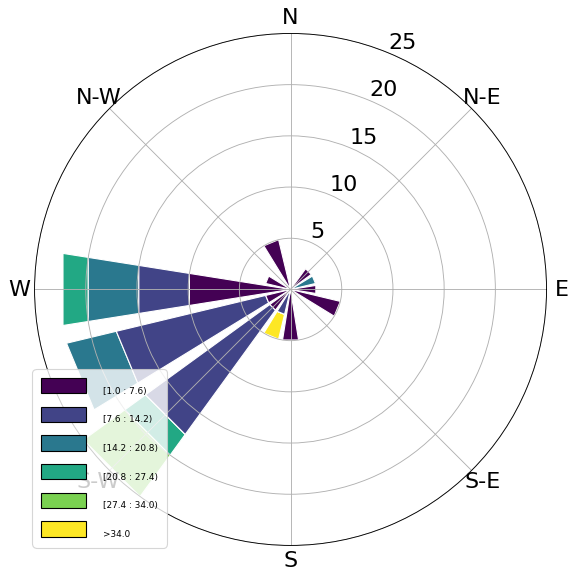

KUFSTEIN 0-20000-0-11130_CEUAS_merged_v1.nc 2357 days 12:00:00


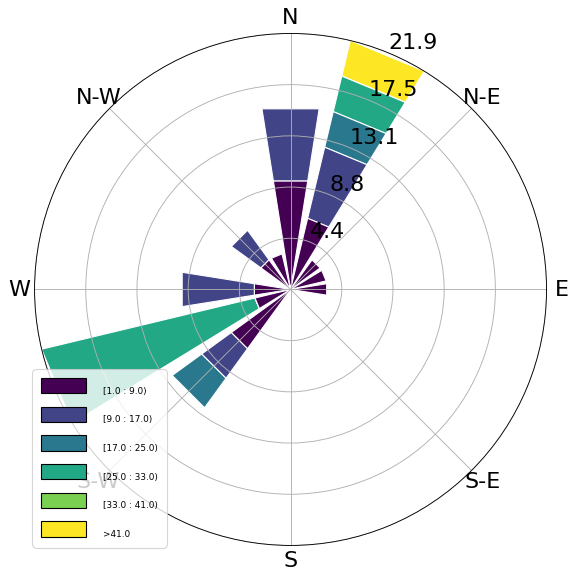

KLAGENFURT-FLUGHAFEN 0-20000-0-11231_CEUAS_merged_v1.nc 18379 days 13:27:00


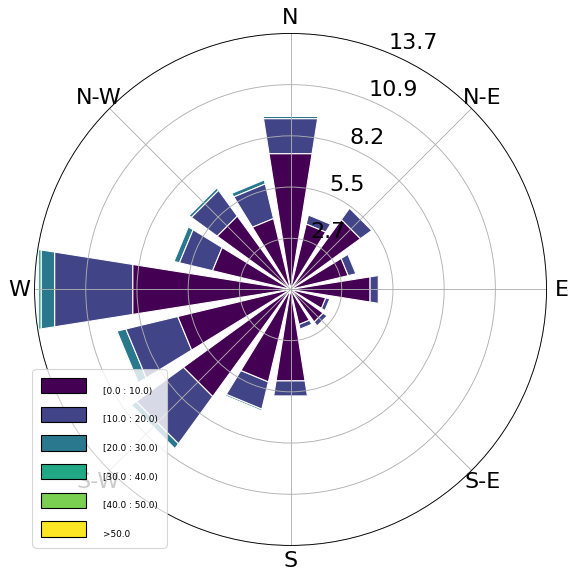

NEUMARKT 0-20000-0-11220_CEUAS_merged_v1.nc 1982 days 12:00:00


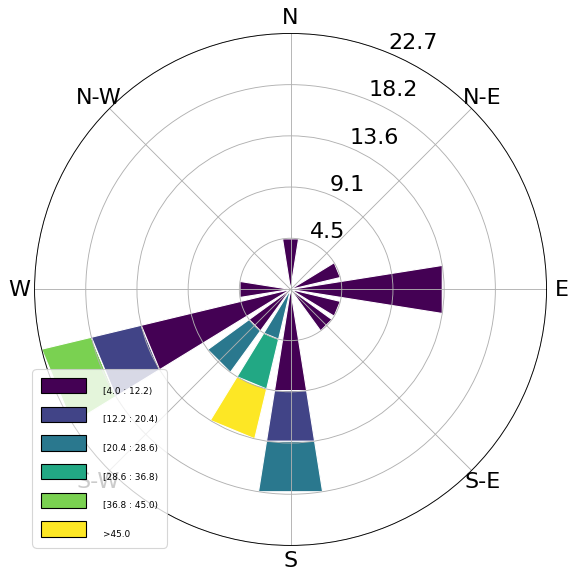

LIENZ 0-20000-0-11204_CEUAS_merged_v1.nc 16588 days 14:48:00


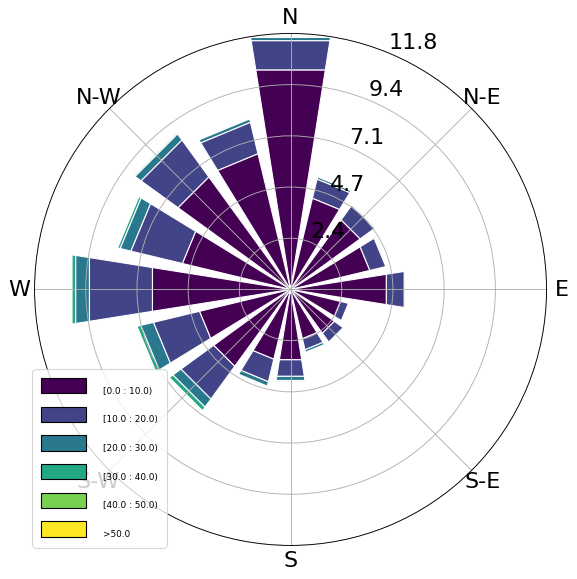

GRAZ-THALERHOF-FLUGHAFEN 0-20000-0-11240_CEUAS_merged_v1.nc 42485 days 13:37:06


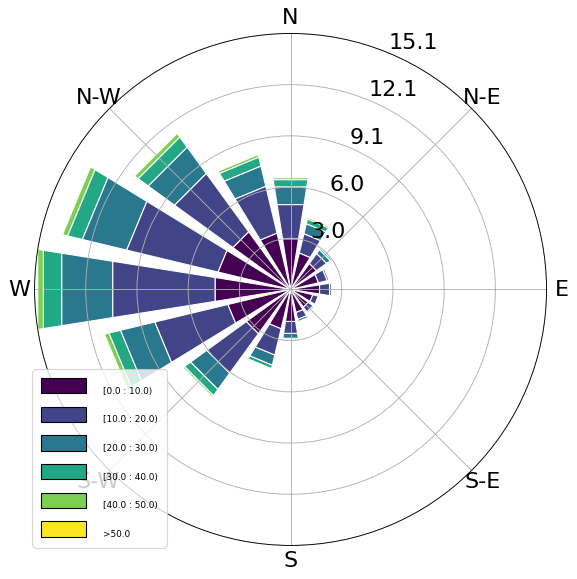

FEISTRITZ OB BLEIBURG 0-20000-0-11232_CEUAS_merged_v1.nc 304 days 18:00:00


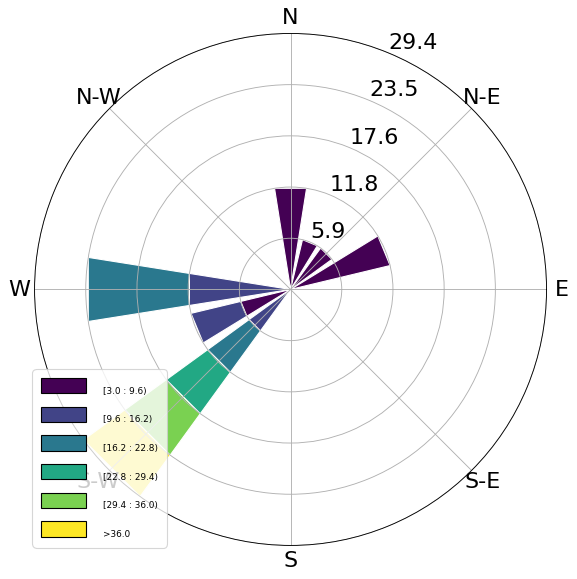

PREITENEGG 0-20000-0-11214_CEUAS_merged_v1.nc 43 days 12:00:00


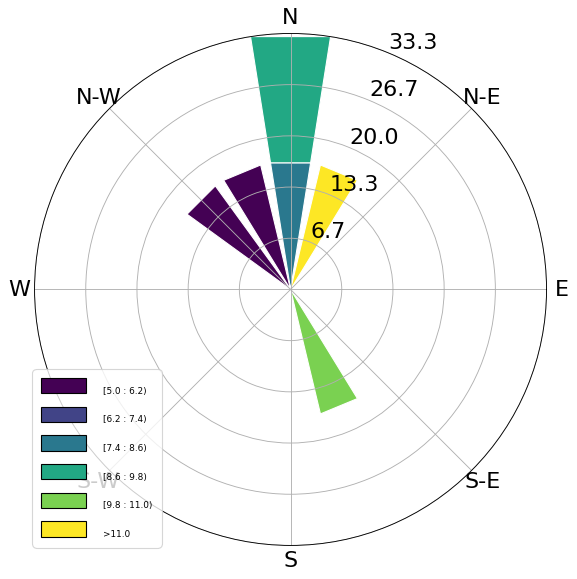

SALZBURG/FREISAAL 0-20000-0-11350_CEUAS_merged_v1.nc 19132 days 10:17:00


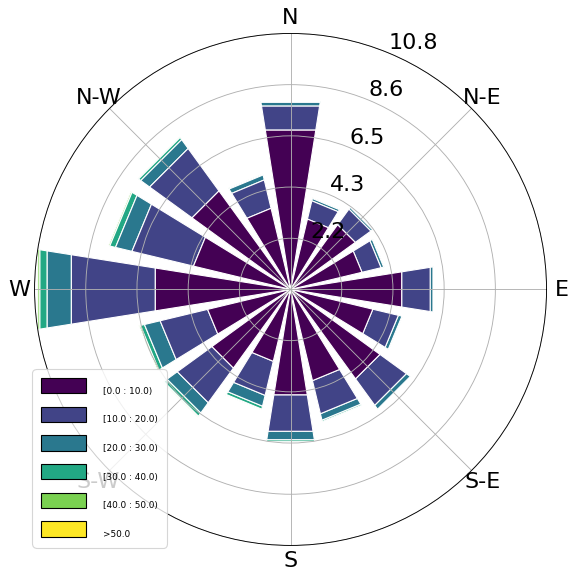

REUTTE 0-20000-0-11314_CEUAS_merged_v1.nc 2208 days 23:00:00


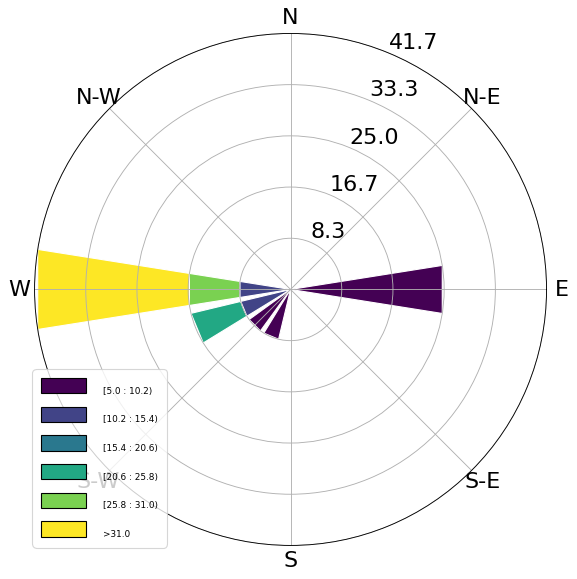

KLAGENFURT-FLUGHAFEN (AUTOMAT) 0-20000-0-11331_CEUAS_merged_v1.nc 19217 days 11:07:00


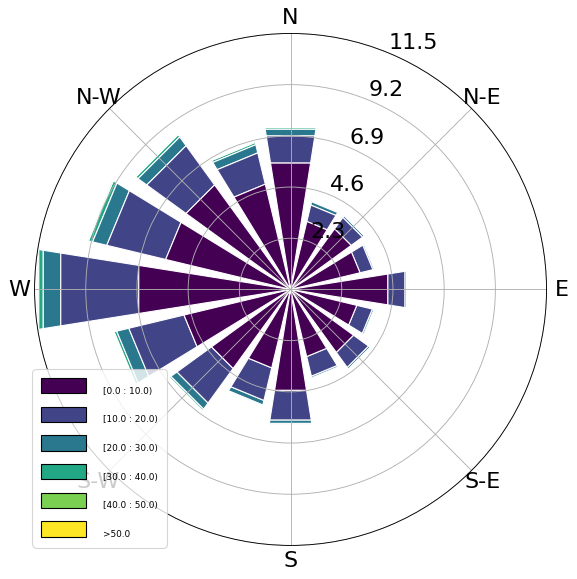

In [9]:
for i in range(len(df)):
    if (df.end[i] != df.start[i]):
        print(df.name[i], df.id[i], (df.end[i] - df.start[i]))
        ax = WindroseAxes.from_ax()
        ax.bar(list(df.wdir[i]), list(df.wspd[i]), normed=True, opening=0.8, edgecolor='white')
        ax.set_legend()
        plt.show()
        plt.close()